#### DACBO Using Blackbox Optimization and Splines

Goal: Learning a piecewise linear function for dynamically tuning hyperparameters in a BO loop. For example, exploration-exploitation parameters in the acquisition function, selecting the acquisition function itself, ... 

##### Setup

- Two nested BO loops
- Setting HP $\beta$ in the UCB acquisition function, where $\beta\in[0,1]$
- Inner loop: Evaluating configuration as proposed by the outer loop. One step $\equiv$ one BO run with proposed $\beta$ schedule
- Outer search strategy: Segment inner optimization budget $[0,T]$ into $K$ segments: $ 0 = \tau_0 < \tau_1 < \cdots < \tau_K = T$. The schedule $\beta_t$ is constrained to be piecewise linear on these segments, therefore uniquely determined by the boundary values:
  $b_i := \beta_{\tau_i}, \quad i = 0, \dots, K$. For $K = 4$, this yields 5 DoFs.
- Outer search space = $[0,1]^{K+1}$, where each point corresponds to one piecewise linear schedule

##### Experiment

- Outer loop: Vanilla SMAC3 BlackBoxFacade, budget of 150
- Inner loop: SMAC3 BlackBoxFacade with UCB acquisition function, budget of 77
- BBOB FIDs: 1, 2, 20
- Trained each on seeds 1, 2, 3

##### Insights

- Not generalizing too well across seeds (duh, why would it?), but able to keep up with SMAC
- When evaluated only on the respective training seed: Very quick progress and strong final performance
- Conclusion: Even with this very simple setup and search space, we are able to learn a schedule that can positively impact the optimization. But: Can we generalize across seeds or target functions?
- Investigate impact of $K$
- Try AC or EA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df

In [2]:
def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
    logs = []
    for p in paths:
        fn = Path(p) / "trajectory.parquet"
        if not fn.is_file():
            fn = Path(p) / "runs/logs.csv"
        logs.append(pd.read_csv(fn))

    df = pd.concat(logs).reset_index(drop=True)
    df_cfg = pd.concat([pd.read_csv(Path(p) / "runs/logs_cfg.csv") for p in paths]).reset_index(drop=True)
    df["set"] = set_id
    return df, df_cfg

In [3]:
PATH = '/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacbo_piecewise'
NAME = 'dacboenv'

In [4]:
def create_df():
    run_dirs = [(PATH, NAME)]
    dfs = [load_set(paths=[ps], set_id=set_id) for ps, set_id in run_dirs]

    df = pd.concat([d for d, _ in dfs]).reset_index(drop=True)
    df = normalize_logs(df)

    perf = get_interpolated_performance_df(df)

    perf_time = get_interpolated_performance_df(df, x_column="time_norm")

    perf.to_parquet(f'{PATH}/perf.parquet')
    perf_time.to_parquet(f'{PATH}/perf_time.parquet')

In [10]:
create_df()

[10:07:50] INFO     Start normalization...                                                       ]8;id=492967;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=766274;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#602\602]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=59130;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=332925;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#603\603]8;;\

           INFO     Normalize cost...                                                            ]8;id=321761;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=971397;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#605\605]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=61686;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=658564;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#621\621]8;;\

           INFO     Normalize time...                                                            ]8;id=472919;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=394430;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#641\641]8;;\

           INFO     Done.                                                                        ]8;id=553238;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=11546;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#644\644]8;;\

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=368757;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=34942;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#718\718]8;;\
                    budget.                                                                                        

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=236036;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=61501;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#718\718]8;;\
                    budget.                                                                                        

In [11]:
# Data loading
df = pd.read_parquet(f'{PATH}/perf.parquet')

In [12]:
final = pd.DataFrame(columns=['optimizer_id', 'task_id', 'incumbent_value', 'seed'])

for problem in df['task_id'].unique():
    filtered = df[df['task_id'] == problem]

    incumbents = filtered.groupby(["optimizer_id", "seed"])["trial_value__cost_inc_norm"].min().reset_index()
    incumbents.columns = ['optimizer_id', 'seed', 'incumbent_value']
    incumbents['task_id'] = problem

    final = pd.concat([final, incumbents], ignore_index=True)

final.to_csv(f'{PATH}/final.csv')

/tmp/ipykernel_1130090/2516198194.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, incumbents], ignore_index=True)


In [13]:
final = pd.read_csv(f'{PATH}/final.csv')

In [19]:
FIGURE_PATH = '../figures'

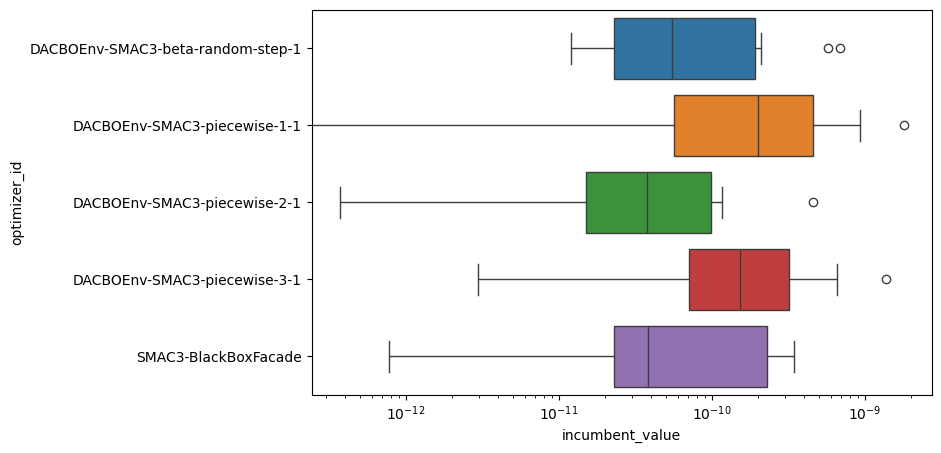

In [ ]:
# Final performance fid 1

plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/1/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')

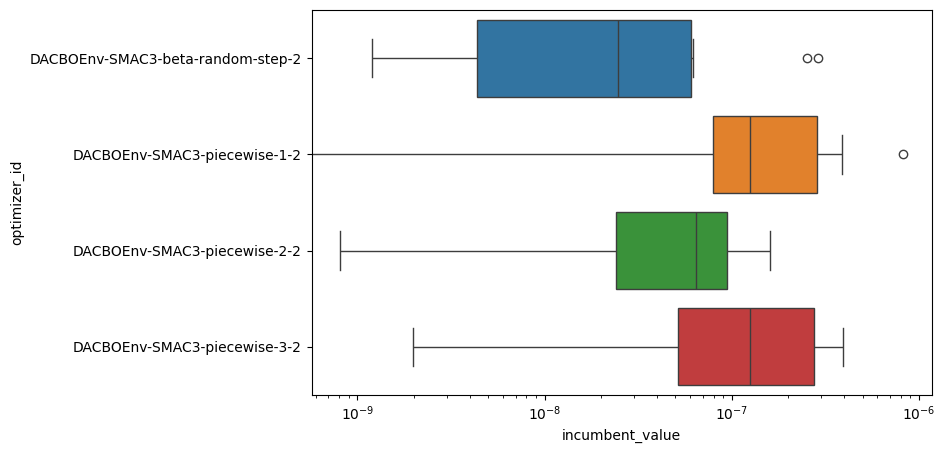

In [ ]:
# Final performance fid 2

plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/2/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')

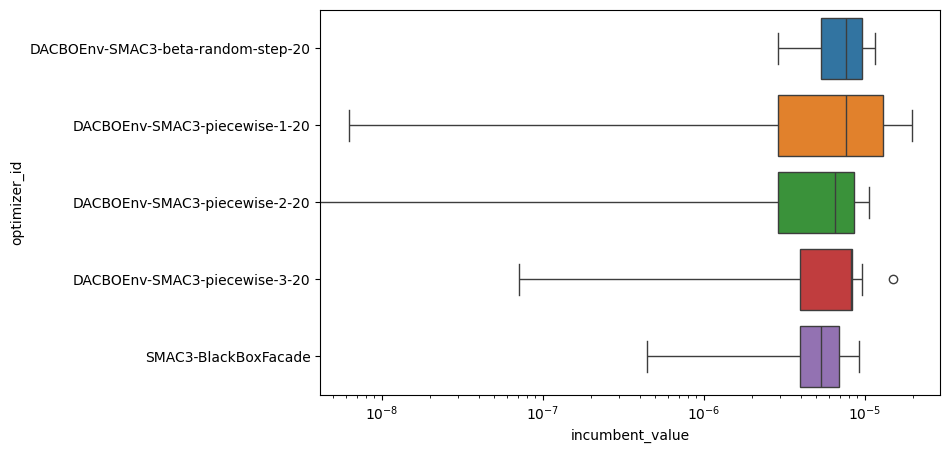

In [ ]:
# Final performance fid 20

plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/20/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')

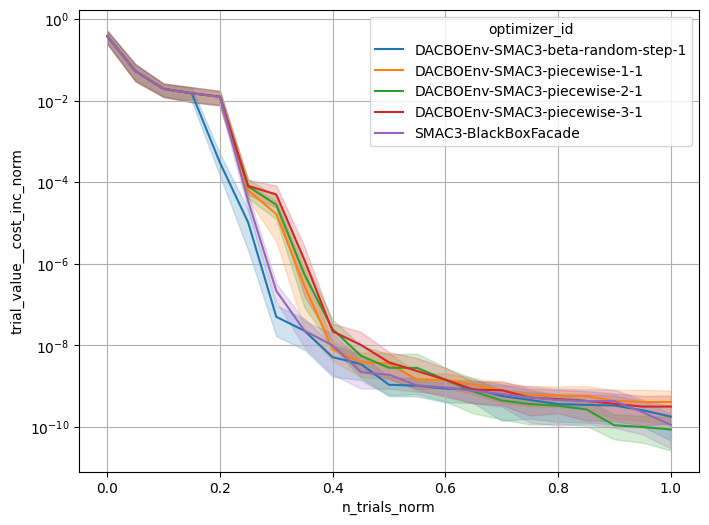

In [ ]:
# Performance over time fid 1, 10 seeds

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0")], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

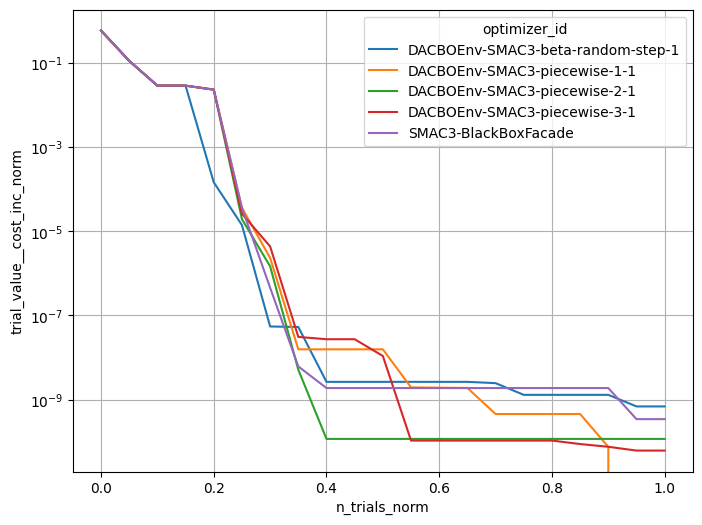

In [ ]:
# Performance over time fid 1, seed 1 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/1/0")) & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

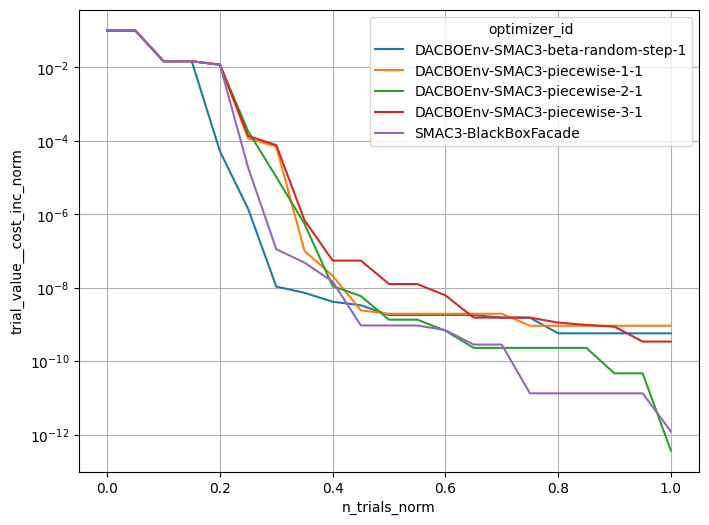

In [ ]:
# Performance over time fid 1, seed 2 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/1/0")) & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

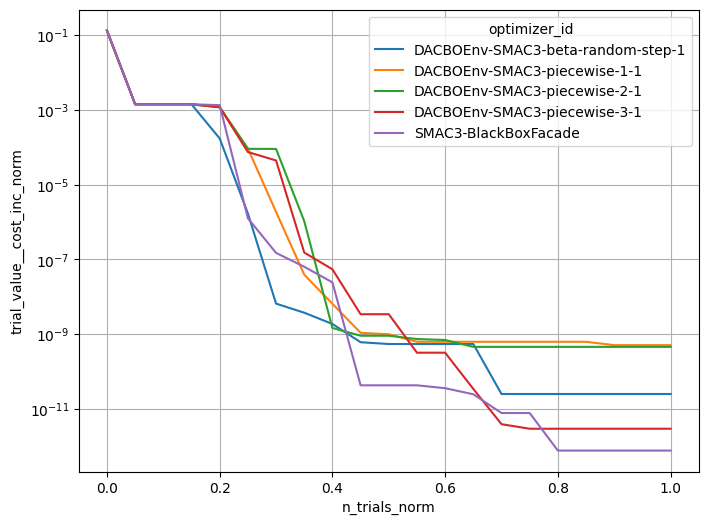

In [ ]:
# Performance over time fid 1, seed 3 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/1/0")) & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

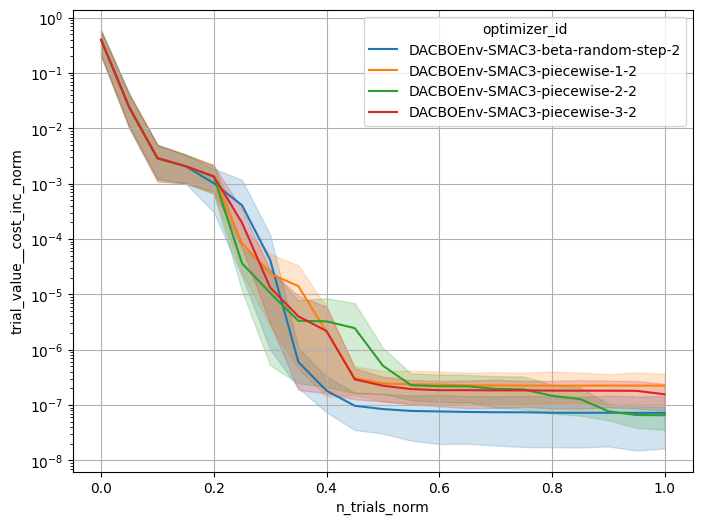

In [ ]:
# Performance over time fid 2, 10 seeds

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/2/0"))], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

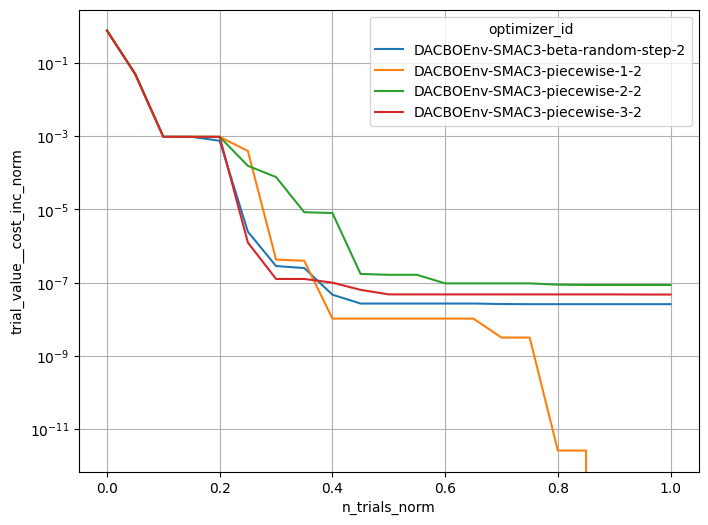

In [ ]:
# Performance over time fid 2, seed 1 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/2/0")) & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

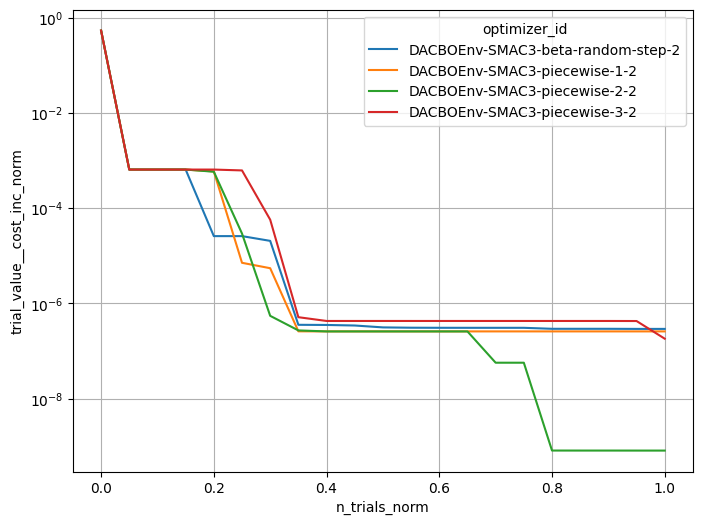

In [ ]:
# Performance over time fid 2, seed 2 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/2/0")) & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

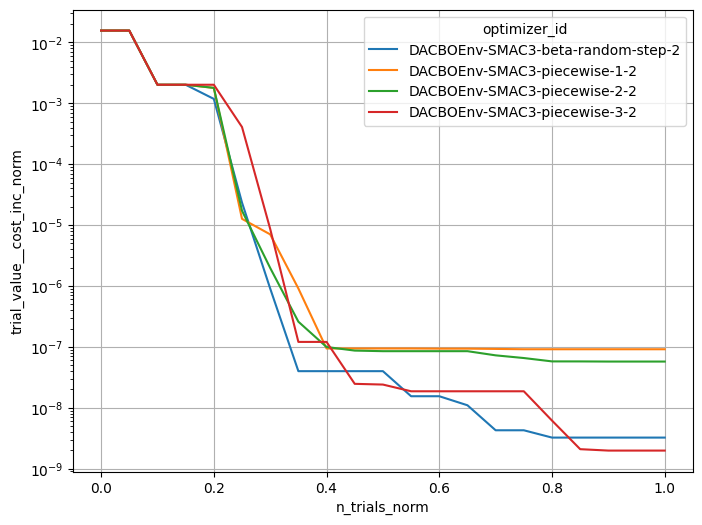

In [ ]:
# Performance over time fid 2, seed 3 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/2/0")) & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

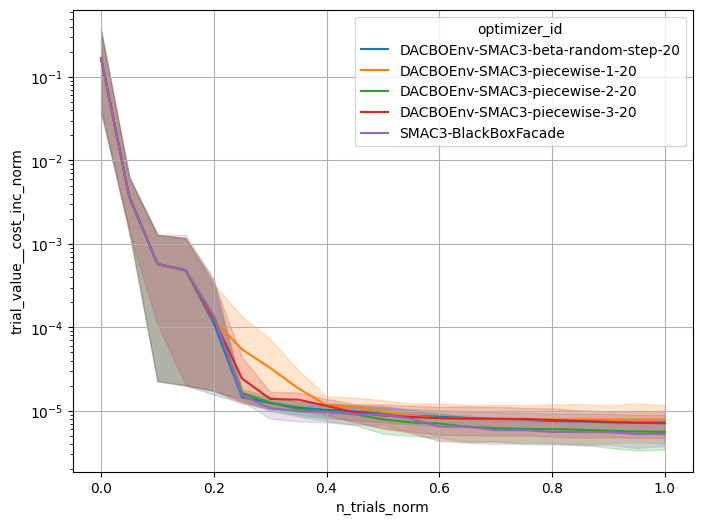

In [ ]:
# Performance over time fid 20, 10 seeds

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/20/0"))], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

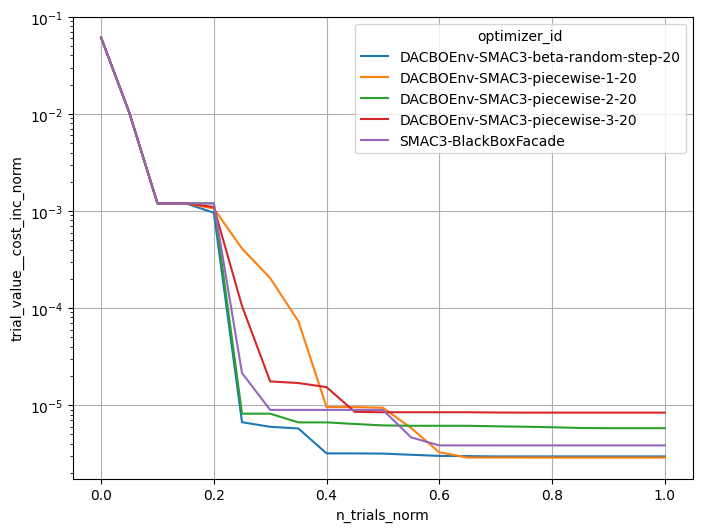

In [ ]:
# Performance over time fid 20, seed 1 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/20/0")) & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

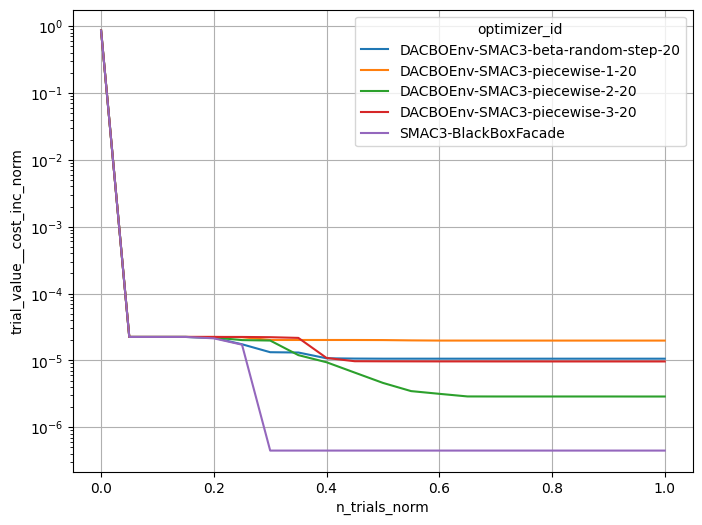

In [ ]:
# Performance over time fid 20, seed 2 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/20/0")) & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

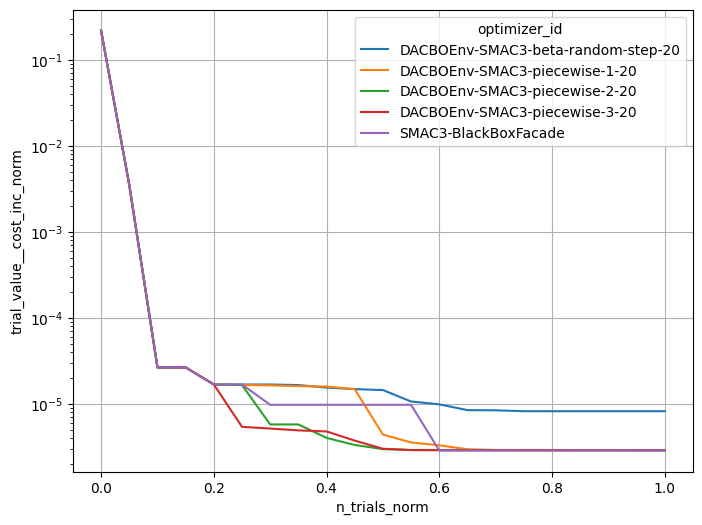

In [ ]:
# Performance over time fid 20, seed 3 only

plt.figure(figsize=(8, 6))
sns.lineplot(data=df[(df["task_id"].str.endswith("/20/0")) & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)